         id  diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302          1        17.99         10.38          122.80     1001.0   
1    842517          1        20.57         17.77          132.90     1326.0   
2  84300903          1        19.69         21.25          130.00     1203.0   
3  84348301          1        11.42         20.38           77.58      386.1   
4  84358402          1        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave_points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_worst  smoo

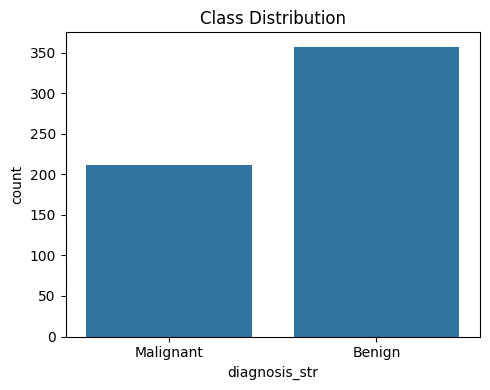

                         count        mean         std         min  \
radius_mean              569.0   14.127292    3.524049    6.981000   
texture_mean             569.0   19.289649    4.301036    9.710000   
perimeter_mean           569.0   91.969033   24.298981   43.790000   
area_mean                569.0  654.889104  351.914129  143.500000   
smoothness_mean          569.0    0.096360    0.014064    0.052630   
compactness_mean         569.0    0.104341    0.052813    0.019380   
concavity_mean           569.0    0.088799    0.079720    0.000000   
concave_points_mean      569.0    0.048919    0.038803    0.000000   
symmetry_mean            569.0    0.181162    0.027414    0.106000   
fractal_dimension_mean   569.0    0.062798    0.007060    0.049960   
radius_se                569.0    0.405172    0.277313    0.111500   
texture_se               569.0    1.216853    0.551648    0.360200   
perimeter_se             569.0    2.866059    2.021855    0.757000   
area_se             

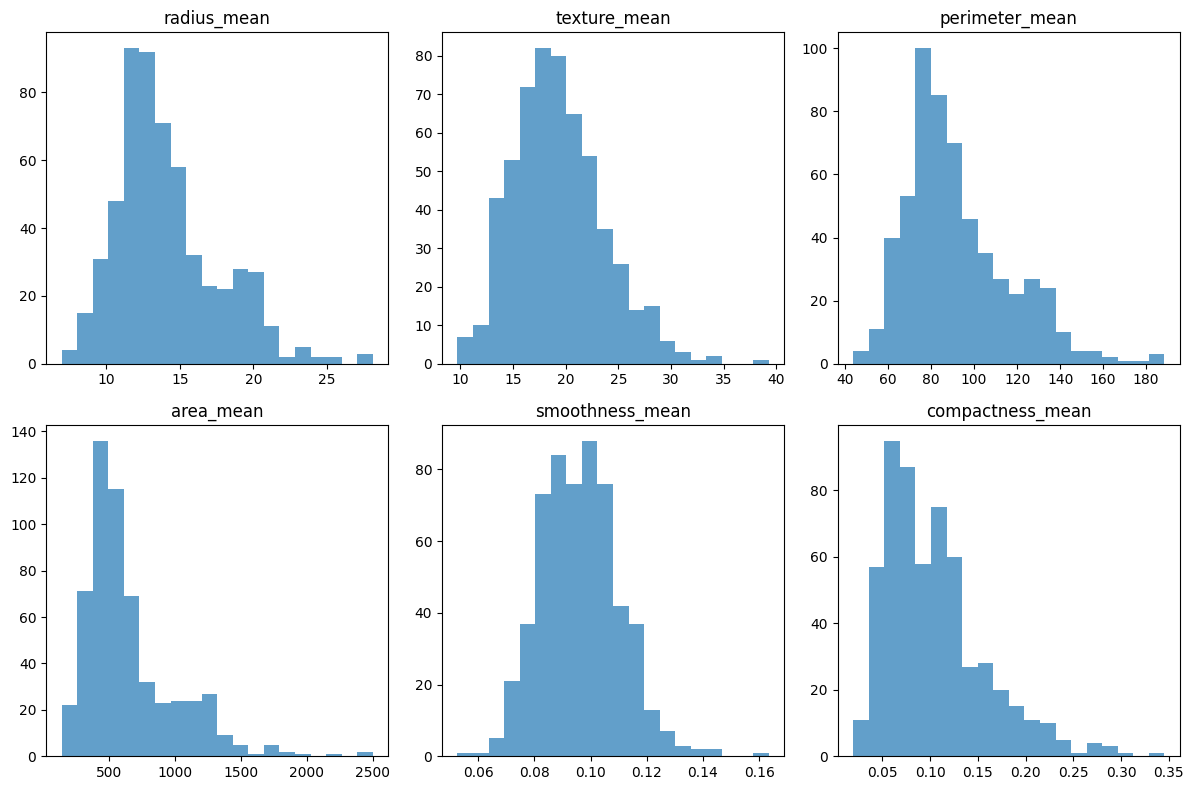

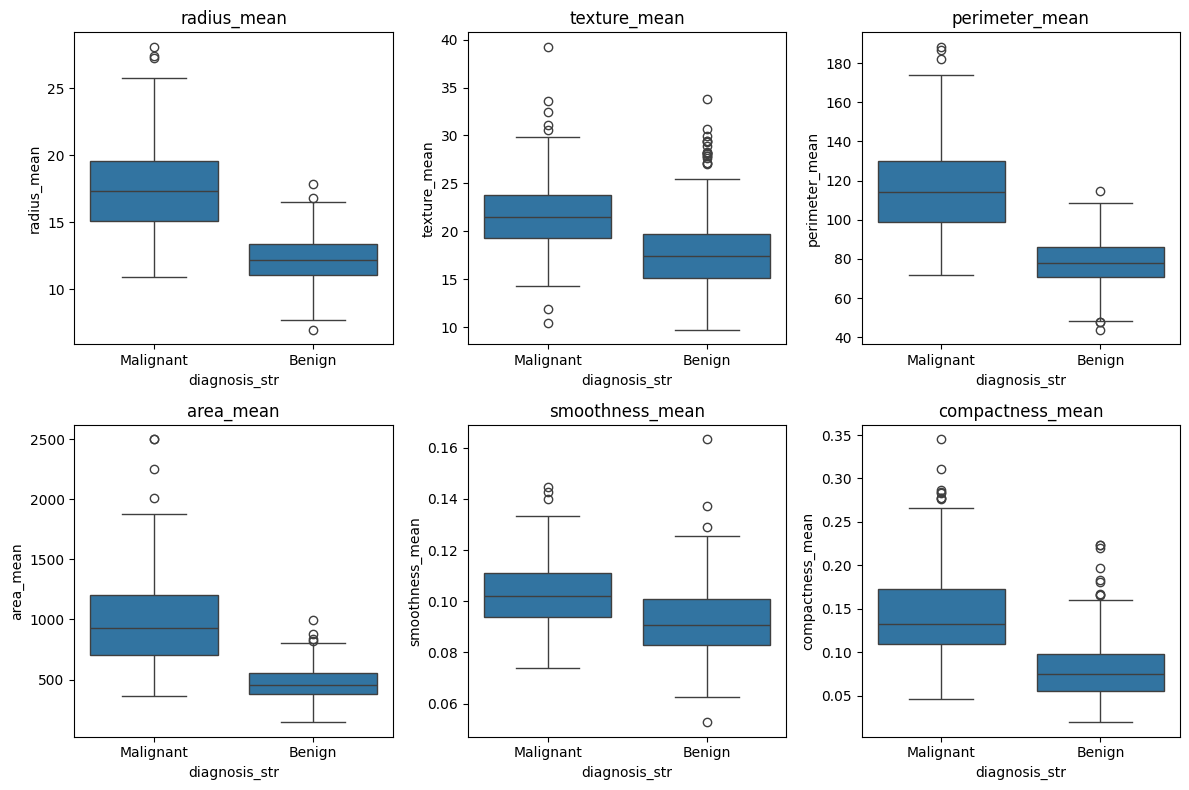

                 feature           F              p
27  concave_points_worst  964.385393  1.969100e-124
22       perimeter_worst  897.944219  5.771397e-119
7    concave_points_mean  861.676020  7.101150e-116
20          radius_worst  860.781707  8.482292e-116
2         perimeter_mean  697.235272  8.436251e-101
23            area_worst  661.600206   2.828848e-97
0            radius_mean  646.981021   8.465941e-96
3              area_mean  573.060747   4.734564e-88
6         concavity_mean  533.793126   9.966556e-84
26       concavity_worst  436.691939   2.464664e-72
Train: 455 Test: 114
Applied global Gaussian shift.

Client splits created.



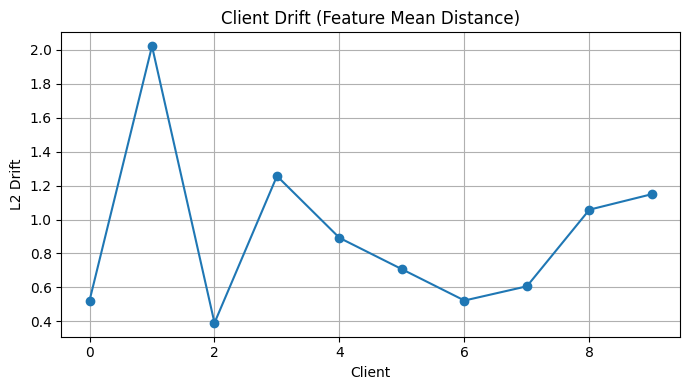

========== RUNNING 5 MLP EXPERIMENTS × 50 TRIALS ==========

========== TRIAL 1/50 ==========

1. Central MLP Baseline (No FL, No DP)
    -> Accuracy=0.9825, Precision=0.9865, Recall=0.9762, F1=0.9810

2. FedAvg MLP (No DP)
    -> Accuracy=0.9561, Precision=0.9675, Recall=0.9405, F1=0.9516

3. FedAvg MLP + DP
    -> Accuracy=0.9561, Precision=0.9675, Recall=0.9405, F1=0.9516

4. FedProx-style MLP (No DP)
    -> Accuracy=0.9474, Precision=0.9615, Recall=0.9286, F1=0.9415

5. FedProx-style MLP + DP
    -> Accuracy=0.9474, Precision=0.9615, Recall=0.9286, F1=0.9415

========== TRIAL 2/50 ==========

1. Central MLP Baseline (No FL, No DP)
    -> Accuracy=0.9737, Precision=0.9800, Recall=0.9643, F1=0.9713

2. FedAvg MLP (No DP)
    -> Accuracy=0.9561, Precision=0.9675, Recall=0.9405, F1=0.9516

3. FedAvg MLP + DP
    -> Accuracy=0.9298, Precision=0.9500, Recall=0.9048, F1=0.9211

4. FedProx-style MLP (No DP)
    -> Accuracy=0.9561, Precision=0.9675, Recall=0.9405, F1=0.9516

5. FedProx-styl

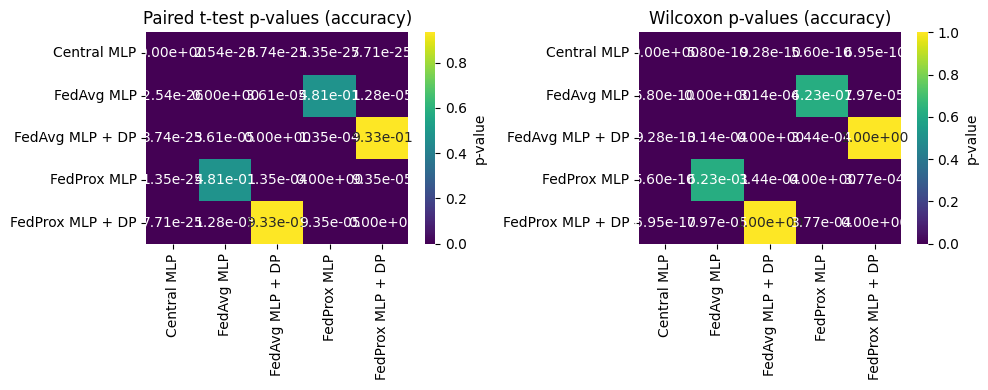

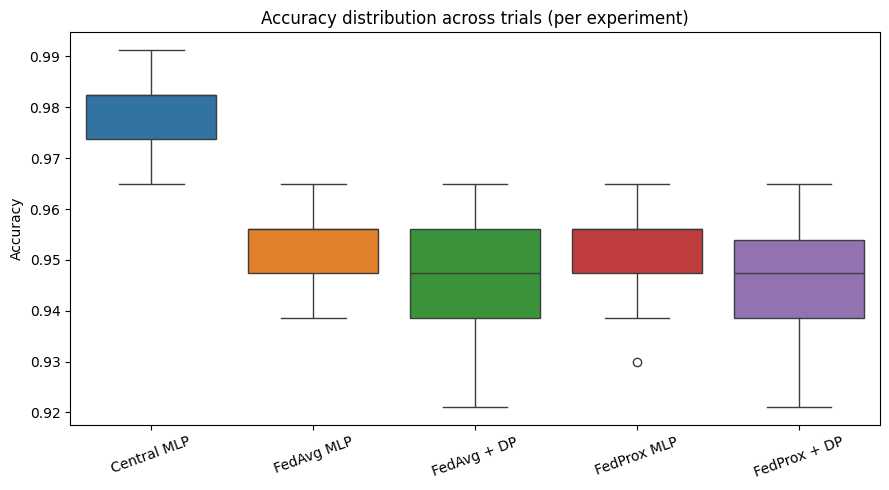

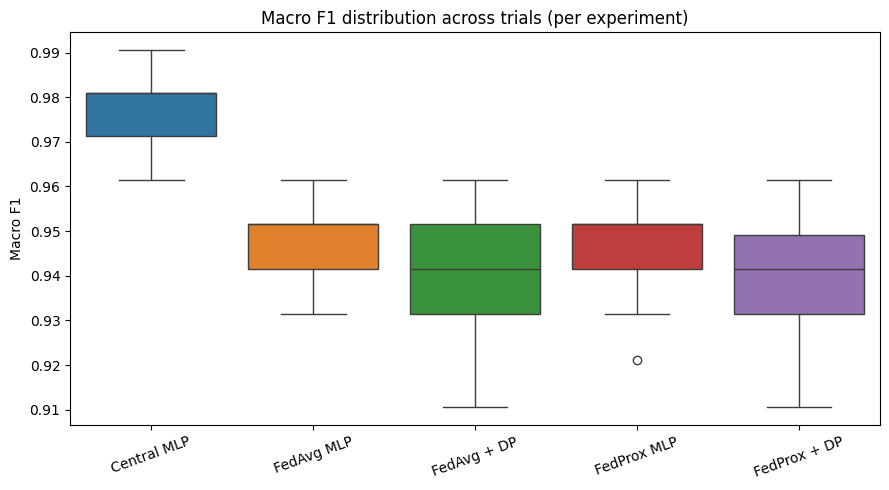


===== FINAL RESULTS TABLE (mean ± std) — '*' indicates significance vs Central (p<0.05) =====

      experiment         accuracy               f1  paired_t_p_acc  wilcoxon_p_acc
     Central MLP  0.9804 ± 0.0071  0.9787 ± 0.0078             NaN             NaN
      FedAvg MLP 0.9521 ± 0.0064* 0.9469 ± 0.0073*    2.538485e-26    5.800894e-10
 FedAvg MLP + DP 0.9439 ± 0.0115* 0.9375 ± 0.0132*    3.741415e-25    9.277622e-10
     FedProx MLP 0.9512 ± 0.0071* 0.9459 ± 0.0081*    1.348295e-25    5.595420e-10
FedProx MLP + DP 0.9437 ± 0.0115* 0.9372 ± 0.0133*    7.712462e-25    6.947929e-10

===== INTERPRETATION HELP =====
 - If Friedman p < 0.05, there is evidence that at least one model differs from others across trials.
 - Use the pairwise Bonferroni-adjusted p-values above to identify which pairs differ.
 - Wilcoxon is more robust if normality assumptions are violated; interpret both tests together when possible.

Done — statistical testing complete.


In [ ]:
# ============================================================
# FULL IMPROVED MLP + FEDERATED LEARNING + DP + STATISTICS
# PART 1 — Imports, EDA, Preprocessing, Client Split, Helpers
# ============================================================

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report
)

# Statistical tests
from scipy.stats import ttest_rel, wilcoxon, friedmanchisquare

# ----------------------------
# GLOBAL CONFIG
# ----------------------------
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

N_CLIENTS = 10
N_TRIALS = 50

GLOBAL_DIST_SHIFT_STD = 0.3     # artificial Gaussian shift
DP_AGG_NOISE_STD = 0.10         # DP noise at aggregation step

FEATURE_SHIFT_CLIENTS = [2, 7]  # simulate extra drift
FEATURE_SHIFT_DELTA = 0.5

# MLP Hyperparameters
MLP_HIDDEN_SIZES = (64, 32)
MLP_LR = 1e-3
MLP_MAX_ITER = 300
MLP_ALPHA_BASE = 1e-3
MLP_ALPHA_PROX = 5e-3  # stronger regularization = FedProx-style


# ============================================================
# 1. LOAD WDBC DATASET
# ============================================================
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"

columns = ['id', 'diagnosis'] + [
    f'{feature}_{stat}'
    for stat in ['mean', 'se', 'worst']
    for feature in [
        'radius', 'texture', 'perimeter', 'area', 'smoothness',
        'compactness', 'concavity', 'concave_points',
        'symmetry', 'fractal_dimension'
    ]
]

df = pd.read_csv(url, header=None, names=columns)
df['diagnosis'] = df['diagnosis'].map({'B': 0, 'M': 1})
df['diagnosis_str'] = df['diagnosis'].map({0: 'Benign', 1: 'Malignant'})

num_cols = df.drop(columns=['id', 'diagnosis', 'diagnosis_str']).columns

print(df.head(), "\n")


# ============================================================
# 2. EXPLORATORY DATA ANALYSIS
# ============================================================

# 2.1 Class distribution
plt.figure(figsize=(5,4))
sns.countplot(x='diagnosis_str', data=df)
plt.title("Class Distribution")
plt.tight_layout()
plt.show()

# 2.2 Summary statistics
print(df[num_cols].describe().T, "\n")

# 2.3 Histograms
selected_feats = ['radius_mean','texture_mean','perimeter_mean','area_mean','smoothness_mean','compactness_mean']
plt.figure(figsize=(12,8))
for i, feat in enumerate(selected_feats):
    plt.subplot(2,3,i+1)
    plt.hist(df[feat], bins=20, alpha=0.7)
    plt.title(feat)
plt.tight_layout()
plt.show()

# 2.4 Boxplots
plt.figure(figsize=(12,8))
for i, feat in enumerate(selected_feats):
    plt.subplot(2,3,i+1)
    sns.boxplot(x='diagnosis_str', y=feat, data=df)
    plt.title(feat)
plt.tight_layout()
plt.show()

# 2.5 ANOVA F-test importance
X_all = df[num_cols].values
y_all = df['diagnosis'].values
f_vals, p_vals = f_classif(X_all, y_all)
anova_df = pd.DataFrame({"feature":num_cols,"F":f_vals,"p":p_vals}).sort_values("F",ascending=False)
print(anova_df.head(10))


# ============================================================
# 3. TRAIN/TEST SPLIT + SCALING
# ============================================================
X = df[num_cols].values.astype(np.float32)
y = df['diagnosis'].values.astype(np.int64)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED
)

print("Train:", len(y_train), "Test:", len(y_test))


# ============================================================
# 4. ONE-TIME GLOBAL SHIFT (SIMULATE DRIFT)
# ============================================================
X_train = X_train + np.random.normal(0, GLOBAL_DIST_SHIFT_STD, X_train.shape)
print("Applied global Gaussian shift.\n")


# ============================================================
# 5. MANUAL CLIENT SPLIT (LOCKED)
# ============================================================
MANUAL_LABEL_ALLOC = [
    (33,19), (10,2), (61,40), (34,31), (23,11),
    (45,21), (33,18), (26,20), (13,5), (7,3)
]

client_totals = [b+m for b,m in MANUAL_LABEL_ALLOC]
assert sum(client_totals) == len(y_train)

ben_idx = np.where(y_train==0)[0].tolist()
mal_idx = np.where(y_train==1)[0].tolist()
random.shuffle(ben_idx)
random.shuffle(mal_idx)

client_indices = []
sb, sm = 0, 0

for b_ct, m_ct in MANUAL_LABEL_ALLOC:
    idx = ben_idx[sb:sb+b_ct] + mal_idx[sm:sm+m_ct]
    random.shuffle(idx)
    client_indices.append(idx)
    sb += b_ct
    sm += m_ct

client_splits = [(X_train[idx], y_train[idx]) for idx in client_indices]

print("Client splits created.\n")


# ============================================================
# 6. HELPER FUNCTIONS
# ============================================================

def train_mlp(X_local, y_local, seed, alpha=MLP_ALPHA_BASE):
    clf = MLPClassifier(
        hidden_layer_sizes=MLP_HIDDEN_SIZES,
        activation='relu',
        solver='adam',
        alpha=alpha,
        learning_rate_init=MLP_LR,
        max_iter=MLP_MAX_ITER,
        random_state=seed
    )
    clf.fit(X_local, y_local)
    return clf


def ensemble_predict(models, sizes, X_eval, dp=False):
    total = sum(sizes)
    proba = np.zeros((X_eval.shape[0], 2))
    for clf, n in zip(models, sizes):
        w = n / total
        proba += w * clf.predict_proba(X_eval)
    if dp:
        proba += np.random.normal(0, DP_AGG_NOISE_STD, proba.shape)
    return (proba[:,1] >= 0.5).astype(int)


def score_vector(y_true, y_pred):
    return (
        accuracy_score(y_true,y_pred),
        precision_score(y_true,y_pred,average='macro'),
        recall_score(y_true,y_pred,average='macro'),
        f1_score(y_true,y_pred,average='macro')
    )


def compute_client_drift(splits):
    global_mean = np.vstack([Xi for Xi,_ in splits]).mean(axis=0)
    return [np.linalg.norm(Xi.mean(axis=0) - global_mean) for Xi,_ in splits]


# Drift visualization
drifts = compute_client_drift(client_splits)
plt.figure(figsize=(7,4))
plt.plot(range(N_CLIENTS), drifts, marker='o')
plt.title("Client Drift (Feature Mean Distance)")
plt.xlabel("Client")
plt.ylabel("L2 Drift")
plt.grid(True)
plt.tight_layout()
plt.show()
# ============================================================
# PART 2 — MLP: 5 Experiments × N_TRIALS, Metrics Collection
# ============================================================

metrics_exp1 = []  # Central MLP baseline
metrics_exp2 = []  # FedAvg MLP
metrics_exp3 = []  # FedAvg MLP + DP
metrics_exp4 = []  # FedProx-style MLP
metrics_exp5 = []  # FedProx-style MLP + DP

print("========== RUNNING 5 MLP EXPERIMENTS ×", N_TRIALS, "TRIALS ==========\n")

for t in range(1, N_TRIALS + 1):
    print(f"========== TRIAL {t}/{N_TRIALS} ==========\n")

    # 1) Central MLP Baseline (No FL, No DP)
    model_central = train_mlp(
        X_train, y_train,
        seed=RANDOM_SEED + 1000 * t,
        alpha=MLP_ALPHA_BASE
    )
    y1 = model_central.predict(X_test)
    acc1, prec1, rec1, f1_1 = score_vector(y_test, y1)
    metrics_exp1.append((acc1, prec1, rec1, f1_1))
    print("1. Central MLP Baseline (No FL, No DP)")
    print(f"    -> Accuracy={acc1:.4f}, Precision={prec1:.4f}, Recall={rec1:.4f}, F1={f1_1:.4f}\n")

    # 2) FedAvg MLP (No DP)
    models2 = []
    sizes2 = []
    for cid, (Xi, yi) in enumerate(client_splits):
        X_loc = Xi.copy()
        if cid in FEATURE_SHIFT_CLIENTS:
            X_loc = X_loc + FEATURE_SHIFT_DELTA
        clf2 = train_mlp(
            X_loc, yi,
            seed=RANDOM_SEED + 2000 * t + cid,
            alpha=MLP_ALPHA_BASE
        )
        models2.append(clf2)
        sizes2.append(len(yi))
    y2 = ensemble_predict(models2, sizes2, X_test, dp=False)
    acc2, prec2, rec2, f1_2 = score_vector(y_test, y2)
    metrics_exp2.append((acc2, prec2, rec2, f1_2))
    print("2. FedAvg MLP (No DP)")
    print(f"    -> Accuracy={acc2:.4f}, Precision={prec2:.4f}, Recall={rec2:.4f}, F1={f1_2:.4f}\n")

    # 3) FedAvg MLP + DP
    y3 = ensemble_predict(models2, sizes2, X_test, dp=True)
    acc3, prec3, rec3, f1_3 = score_vector(y_test, y3)
    metrics_exp3.append((acc3, prec3, rec3, f1_3))
    print("3. FedAvg MLP + DP")
    print(f"    -> Accuracy={acc3:.4f}, Precision={prec3:.4f}, Recall={rec3:.4f}, F1={f1_3:.4f}\n")

    # 4) FedProx-style MLP (No DP) — implemented via stronger L2 (alpha)
    models4 = []
    sizes4 = []
    for cid, (Xi, yi) in enumerate(client_splits):
        X_loc = Xi.copy()
        if cid in FEATURE_SHIFT_CLIENTS:
            X_loc = X_loc + FEATURE_SHIFT_DELTA
        clf4 = train_mlp(
            X_loc, yi,
            seed=RANDOM_SEED + 3000 * t + cid,
            alpha=MLP_ALPHA_PROX
        )
        models4.append(clf4)
        sizes4.append(len(yi))
    y4 = ensemble_predict(models4, sizes4, X_test, dp=False)
    acc4, prec4, rec4, f1_4 = score_vector(y_test, y4)
    metrics_exp4.append((acc4, prec4, rec4, f1_4))
    print("4. FedProx-style MLP (No DP)")
    print(f"    -> Accuracy={acc4:.4f}, Precision={prec4:.4f}, Recall={rec4:.4f}, F1={f1_4:.4f}\n")

    # 5) FedProx-style MLP + DP
    y5 = ensemble_predict(models4, sizes4, X_test, dp=True)
    acc5, prec5, rec5, f1_5 = score_vector(y_test, y5)
    metrics_exp5.append((acc5, prec5, rec5, f1_5))
    print("5. FedProx-style MLP + DP")
    print(f"    -> Accuracy={acc5:.4f}, Precision={prec5:.4f}, Recall={rec5:.4f}, F1={f1_5:.4f}\n")

print("\n========== ALL TRIALS COMPLETE ==========\n")


# ============================================================
# METRIC SUMMARY (MEAN ± STD)
# ============================================================
cols = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
df1 = pd.DataFrame(metrics_exp1, columns=cols)
df2 = pd.DataFrame(metrics_exp2, columns=cols)
df3 = pd.DataFrame(metrics_exp3, columns=cols)
df4 = pd.DataFrame(metrics_exp4, columns=cols)
df5 = pd.DataFrame(metrics_exp5, columns=cols)

summary_df = pd.DataFrame({
    "experiment": [
        "Central MLP Baseline",
        "FedAvg MLP",
        "FedAvg MLP + DP",
        "FedProx MLP",
        "FedProx MLP + DP"
    ],
    "accuracy_mean":  [df.mean()['accuracy']        for df in [df1, df2, df3, df4, df5]],
    "accuracy_std":   [df.std()['accuracy']         for df in [df1, df2, df3, df4, df5]],
    "f1_mean":        [df.mean()['f1_macro']        for df in [df1, df2, df3, df4, df5]],
    "f1_std":         [df.std()['f1_macro']         for df in [df1, df2, df3, df4, df5]],
    "prec_mean":      [df.mean()['precision_macro'] for df in [df1, df2, df3, df4, df5]],
    "recall_mean":    [df.mean()['recall_macro']    for df in [df1, df2, df3, df4, df5]],
})

print("===== EVALUATION METRIC SUMMARY (MEAN ± STD over trials) =====\n")
print(summary_df.round(4).to_string(index=False))


# ============================================================
# BEST TRIAL REPORTS
# ============================================================
# Best FedAvg trial (no DP)
best_fedavg_idx = int(np.argmax(df2['f1_macro'].values))
print(f"\nBest FedAvg MLP (No DP) trial index (0-based): {best_fedavg_idx}")
t_best_fedavg = best_fedavg_idx + 1

models2_best = []
sizes2_best = []
for cid, (Xi, yi) in enumerate(client_splits):
    X_loc = Xi.copy()
    if cid in FEATURE_SHIFT_CLIENTS:
        X_loc = X_loc + FEATURE_SHIFT_DELTA
    clf2_best = train_mlp(
        X_loc, yi,
        seed=RANDOM_SEED + 2000 * t_best_fedavg + cid,
        alpha=MLP_ALPHA_BASE
    )
    models2_best.append(clf2_best)
    sizes2_best.append(len(yi))

y2_best = ensemble_predict(models2_best, sizes2_best, X_test, dp=False)
print("\n===== CLASSIFICATION REPORT: BEST FedAvg MLP (No DP) TRIAL =====\n")
print(classification_report(y_test, y2_best))


# Best FedProx trial (no DP)
best_fedprox_idx = int(np.argmax(df4['f1_macro'].values))
print(f"\nBest FedProx MLP (No DP) trial index (0-based): {best_fedprox_idx}")
t_best_fedprox = best_fedprox_idx + 1

models4_best = []
sizes4_best = []
for cid, (Xi, yi) in enumerate(client_splits):
    X_loc = Xi.copy()
    if cid in FEATURE_SHIFT_CLIENTS:
        X_loc = X_loc + FEATURE_SHIFT_DELTA
    clf4_best = train_mlp(
        X_loc, yi,
        seed=RANDOM_SEED + 3000 * t_best_fedprox + cid,
        alpha=MLP_ALPHA_PROX
    )
    models4_best.append(clf4_best)
    sizes4_best.append(len(yi))

y4_best = ensemble_predict(models4_best, sizes4_best, X_test, dp=False)
print("\n===== CLASSIFICATION REPORT: BEST FedProx MLP (No DP) TRIAL =====\n")
print(classification_report(y_test, y4_best))
# ============================================================
# PART 3 — Statistical tests, adjusted p-values, plots, final table
# ============================================================

import itertools
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel, wilcoxon, friedmanchisquare

# Gather metric arrays (shape: 5 experiments × N_TRIALS)
acc_matrix = np.vstack([
    df1['accuracy'].values,
    df2['accuracy'].values,
    df3['accuracy'].values,
    df4['accuracy'].values,
    df5['accuracy'].values
])

f1_matrix = np.vstack([
    df1['f1_macro'].values,
    df2['f1_macro'].values,
    df3['f1_macro'].values,
    df4['f1_macro'].values,
    df5['f1_macro'].values
])

exp_names = [
    "Central MLP",
    "FedAvg MLP",
    "FedAvg MLP + DP",
    "FedProx MLP",
    "FedProx MLP + DP"
]

# Helper: all pair indices
pairs = list(itertools.combinations(range(5), 2))
n_pairs = len(pairs)

print("\n====================================================")
print("        STATISTICAL COMPARISONS (PAIRWISE)")
print("====================================================\n")

# -------------------------
# Paired t-tests
# -------------------------
ttest_results_acc = {}
ttest_results_f1 = {}
print("Paired t-tests (accuracy):")
for (i, j) in pairs:
    t_stat, p_val = ttest_rel(acc_matrix[i], acc_matrix[j])
    ttest_results_acc[(i,j)] = p_val
    print(f"  {exp_names[i]} vs {exp_names[j]}: p = {p_val:.6e}")
print("")

print("Paired t-tests (macro F1):")
for (i, j) in pairs:
    t_stat, p_val = ttest_rel(f1_matrix[i], f1_matrix[j])
    ttest_results_f1[(i,j)] = p_val
    print(f"  {exp_names[i]} vs {exp_names[j]}: p = {p_val:.6e}")
print("")

# -------------------------
# Wilcoxon signed-rank tests (non-parametric)
# -------------------------
wilcoxon_results_acc = {}
wilcoxon_results_f1 = {}
print("Wilcoxon signed-rank tests (accuracy):")
for (i, j) in pairs:
    try:
        stat, p_val = wilcoxon(acc_matrix[i], acc_matrix[j])
        wilcoxon_results_acc[(i,j)] = p_val
        print(f"  {exp_names[i]} vs {exp_names[j]}: p = {p_val:.6e}")
    except Exception as e:
        wilcoxon_results_acc[(i,j)] = np.nan
        print(f"  {exp_names[i]} vs {exp_names[j]}: ERROR / not enough variation ({e})")
print("")

print("Wilcoxon signed-rank tests (macro F1):")
for (i, j) in pairs:
    try:
        stat, p_val = wilcoxon(f1_matrix[i], f1_matrix[j])
        wilcoxon_results_f1[(i,j)] = p_val
        print(f"  {exp_names[i]} vs {exp_names[j]}: p = {p_val:.6e}")
    except Exception as e:
        wilcoxon_results_f1[(i,j)] = np.nan
        print(f"  {exp_names[i]} vs {exp_names[j]}: ERROR / not enough variation ({e})")
print("")

# -------------------------
# Multiple comparison correction: Bonferroni
# -------------------------
def bonferroni_adjust(p_dict):
    """Return dict of adjusted p-values (Bonferroni) clipped to 1.0"""
    adjusted = {}
    for k, p in p_dict.items():
        if p is None or (isinstance(p, float) and np.isnan(p)):
            adjusted[k] = np.nan
        else:
            adj = min(1.0, p * n_pairs)
            adjusted[k] = adj
    return adjusted

ttest_acc_bonf = bonferroni_adjust(ttest_results_acc)
ttest_f1_bonf  = bonferroni_adjust(ttest_results_f1)
wilc_acc_bonf  = bonferroni_adjust(wilcoxon_results_acc)
wilc_f1_bonf   = bonferroni_adjust(wilcoxon_results_f1)

print("Bonferroni-adjusted (paired t-test) p-values (accuracy):")
for (i,j), p in ttest_acc_bonf.items():
    print(f"  {exp_names[i]} vs {exp_names[j]}: p_adj = {p:.6e}")
print("")

print("Bonferroni-adjusted (Wilcoxon) p-values (accuracy):")
for (i,j), p in wilc_acc_bonf.items():
    print(f"  {exp_names[i]} vs {exp_names[j]}: p_adj = {p if not np.isnan(p) else 'nan'}")
print("")

# -------------------------
# Friedman test (multi-model)
# -------------------------
print("Friedman test across all 5 models (accuracy):")
fried_acc = friedmanchisquare(*[acc_matrix[k] for k in range(5)])
print(f"  statistic={fried_acc.statistic:.4f}, p={fried_acc.pvalue:.6e}")

print("Friedman test across all 5 models (macro F1):")
fried_f1 = friedmanchisquare(*[f1_matrix[k] for k in range(5)])
print(f"  statistic={fried_f1.statistic:.4f}, p={fried_f1.pvalue:.6e}")
print("")

# -------------------------
# Create pairwise p-value matrices (for heatmap)
# -------------------------
def make_pval_matrix(pdict):
    mat = np.ones((5,5))
    for (i,j), p in pdict.items():
        mat[i,j] = p if not np.isnan(p) else np.nan
        mat[j,i] = mat[i,j]
    np.fill_diagonal(mat, 0.0)
    return mat

p_ttest_acc_mat = make_pval_matrix(ttest_results_acc)
p_wilc_acc_mat = make_pval_matrix(wilcoxon_results_acc)

# Plot heatmaps of raw p-values (accuracy) for t-test and Wilcoxon
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.heatmap(p_ttest_acc_mat, annot=True, fmt=".2e", xticklabels=exp_names, yticklabels=exp_names, cmap="viridis", cbar_kws={'label':'p-value'})
plt.title("Paired t-test p-values (accuracy)")
plt.subplot(1,2,2)
sns.heatmap(p_wilc_acc_mat, annot=True, fmt=".2e", xticklabels=exp_names, yticklabels=exp_names, cmap="viridis", cbar_kws={'label':'p-value'})
plt.title("Wilcoxon p-values (accuracy)")
plt.tight_layout()
plt.show()

# -------------------------
# Boxplots of accuracies and F1s across trials
# -------------------------
acc_df_plot = pd.DataFrame({
    'Central MLP': acc_matrix[0],
    'FedAvg MLP': acc_matrix[1],
    'FedAvg + DP': acc_matrix[2],
    'FedProx MLP': acc_matrix[3],
    'FedProx + DP': acc_matrix[4],
})

plt.figure(figsize=(9,5))
sns.boxplot(data=acc_df_plot)
plt.title("Accuracy distribution across trials (per experiment)")
plt.ylabel("Accuracy")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

f1_df_plot = pd.DataFrame({
    'Central MLP': f1_matrix[0],
    'FedAvg MLP': f1_matrix[1],
    'FedAvg + DP': f1_matrix[2],
    'FedProx MLP': f1_matrix[3],
    'FedProx + DP': f1_matrix[4],
})

plt.figure(figsize=(9,5))
sns.boxplot(data=f1_df_plot)
plt.title("Macro F1 distribution across trials (per experiment)")
plt.ylabel("Macro F1")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# -------------------------
# Final publication-quality table with significance vs Central baseline
# -------------------------
# We'll test each experiment vs Central (index 0) using paired t-test and wilcoxon (raw p-values)
vs_central = []
alpha = 0.05
for k in range(5):
    mean_acc = acc_matrix[k].mean()
    std_acc = acc_matrix[k].std()
    mean_f1 = f1_matrix[k].mean()
    std_f1 = f1_matrix[k].std()

    if k == 0:
        t_p_acc = np.nan
        w_p_acc = np.nan
        sig_t = False
        sig_w = False
    else:
        t_p_acc = ttest_results_acc.get((0,k), ttest_results_acc.get((k,0), np.nan))
        w_p_acc = wilcoxon_results_acc.get((0,k), wilcoxon_results_acc.get((k,0), np.nan))
        sig_t = (not np.isnan(t_p_acc)) and (t_p_acc < alpha)
        sig_w = (not np.isnan(w_p_acc)) and (w_p_acc < alpha)

    star = ""
    if sig_t or sig_w:
        star = "*"  # significant vs central by at least one test

    vs_central.append({
        "experiment": exp_names[k],
        "accuracy_mean": mean_acc,
        "accuracy_std": std_acc,
        "f1_mean": mean_f1,
        "f1_std": std_f1,
        "sig_vs_central": star,
        "paired_t_p_acc": t_p_acc,
        "wilcoxon_p_acc": w_p_acc
    })

final_table = pd.DataFrame(vs_central)
final_table_display = final_table.copy()
final_table_display['accuracy'] = final_table_display.apply(lambda r: f"{r['accuracy_mean']:.4f} ± {r['accuracy_std']:.4f}{r['sig_vs_central']}", axis=1)
final_table_display['f1'] = final_table_display.apply(lambda r: f"{r['f1_mean']:.4f} ± {r['f1_std']:.4f}{r['sig_vs_central']}", axis=1)
final_table_display = final_table_display[['experiment','accuracy','f1','paired_t_p_acc','wilcoxon_p_acc']]
print("\n===== FINAL RESULTS TABLE (mean ± std) — '*' indicates significance vs Central (p<0.05) =====\n")
print(final_table_display.to_string(index=False))

# -------------------------
# Summary of Friedman result interpretation
# -------------------------
print("\n===== INTERPRETATION HELP =====")
print(" - If Friedman p < 0.05, there is evidence that at least one model differs from others across trials.")
print(" - Use the pairwise Bonferroni-adjusted p-values above to identify which pairs differ.")
print(" - Wilcoxon is more robust if normality assumptions are violated; interpret both tests together when possible.")
print("\nDone — statistical testing complete.")